In [1]:

import json
import logging
from pathlib import Path
from copy import deepcopy

import cv2
import numpy as np
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
import pandas as pd
from typing import Dict, Any, List
from matplotlib.lines import Line2D
from torchvision.transforms import InterpolationMode


# ---------------------------
# LOGGING & CONFIG
# ---------------------------
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# CONFIGURATION
COCO_JSON        = Path("../data/rotation/batches/rotation_20250721_01/annotations/instances_default.json")
IMAGES_DIR       = Path("../data/rotation/batches/rotation_20250721_01/images/default/")
PRED_JSON        = Path("../data/rotation/batches/rotation_20250721_01/annotations/instances_predicted.json")
COCO_5OBB       = Path("../data/rotation/batches/rotation_20250721_01/annotations/instances_updated.json")
CHECKPOINT_PATH = Path("checkpoints/best_model.pth")

BATCHES_DIR = Path("../data/rotation/batches/")


CLASS_NAMES = [0, 180, 270, 90 ]
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

IMAGE_SIZE = 300

TRANSFORM = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE),
    interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [2]:
# ---------------------------
# I/O
# ---------------------------
def load_coco(path: Path) -> dict:
    logger.info(f"Loading COCO from {path}")
    return json.loads(path.read_text(encoding="utf-8"))

def save_coco(coco: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    logger.info(f"Writing COCO to {path}")
    path.write_text(json.dumps(coco, ensure_ascii=False, indent=2), encoding="utf-8")

# ---------------------------
# MODEL
# ---------------------------
def load_model(ckpt_path: Path) -> nn.Module:
    logger.info(f"Loading model from {ckpt_path}")
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, len(CLASS_NAMES))
    ckpt = torch.load(str(ckpt_path), map_location=DEVICE)
    model.load_state_dict(ckpt["model_state_dict"])
    return model.to(DEVICE).eval()

## Convert Coco to 5 Tuples 

In [3]:
def create_obb_tuple(anns: Dict[str, Any]) -> None:
    """
    Convert axis-aligned bbox [x, y, w, h] to oriented bbox [cx, cy, w, h, angle].
    Added validation and debug logging in place of print statements.
    """
    bbox = anns.get("bbox")
    if isinstance(bbox, list) and len(bbox) == 4:
        x, y, w, h = bbox
        cx = x + w / 2
        cy = y + h / 2
        angle = anns.get("attributes", {}).get("rotation", 0.0)
        anns["bbox"] = [cx, cy, w, h, angle]
        logger.debug(f"Converted bbox to OBB: {anns['bbox']} for annotation id {anns.get('id')}")
    else:
        logger.warning(f"Unexpected bbox format for annotation id {anns.get('id')}: {bbox}")

def replace_obb(coco: Dict[str, Any], batch_dir: Path) -> None:
    """
    Apply create_obb_tuple to all annotations and write updated JSON efficiently.
    """
    logger.info("Replacing OBBs in annotations")
    for anns in coco.get('annotations', []):
        create_obb_tuple(anns)

    #out_path = batch_dir / "annotations" / "instances_updated.json"
    out_path = COCO_5OBB
    logger.info(f"Writing updated annotations to {out_path}")
    with open(out_path, 'w', encoding='utf-8') as f:
        # Use json.dump for more efficient writing
        json.dump(coco, f, ensure_ascii=False)


def convert_all_batches() -> None:
    """
    Iterate over all batch directories and update OBBs.
    """
    for p in BATCHES_DIR.iterdir():
        if "rotation" in p.name:
            json_path = p / "annotations" / "instances_default.json"
            if json_path.exists():
                logger.info(f"Processing batch: {p.name}")
                coco = load_coco(json_path)
                replace_obb(coco, p)
            else:
                logger.warning(f"Missing JSON at {json_path}")
                


#convert_all_batches()

In [12]:
# ---------------------------
# HELPERS
# ---------------------------
def extract_current_rotation(ann: dict) -> float:
    bb = ann.get("bbox", [])
    if len(bb) == 5:
        return float(bb[4])
    attrs = ann.get("attributes", {})
    return float(attrs.get("rotation", 0.0))


def crop_oriented_bbox(img: np.ndarray, cx: float, cy: float, w: float, h: float, theta: float) -> np.ndarray:
    """
    Rotate the image around (cx, cy) by theta then crop the axis-aligned box.
    """
    M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
    rotated = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

    x1 = int(cx - w/2)
    y1 = int(cy - h/2)
    x2 = int(cx + w/2)
    y2 = int(cy + h/2)
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(img.shape[1], x2), min(img.shape[0], y2)

    return rotated[y1:y2, x1:x2], (x1, y1, x2, y2)


In [12]:
def crop_obb_exact_mask_trim(
        img   : np.ndarray,
        cx    : float,
        cy    : float,
        w     : float,
        h     : float,
        angle : float,
        pad   : int = 0
) -> np.ndarray:
    """Same behaviour as crop_obb_exact_mask but returns *no* black border."""
    theta  = np.deg2rad(angle)                      # CCW positive
    ct, st = np.cos(theta), np.sin(theta)

    local  = np.float32([[-w/2, -h/2],
                         [ w/2, -h/2],
                         [ w/2,  h/2],
                         [-w/2,  h/2]])
    R      = np.float32([[ct, -st], [st, ct]])
    poly   = (local @ R.T) + np.float32([cx, cy])

    xs, ys = poly[:, 0], poly[:, 1]
    x0, x1 = int(np.floor(xs.min())) - pad, int(np.ceil(xs.max())) + pad
    y0, y1 = int(np.floor(ys.min())) - pad, int(np.ceil(ys.max())) + pad
    x0 = max(0, x0); y0 = max(0, y0)
    x1 = min(img.shape[1]-1, x1); y1 = min(img.shape[0]-1, y1)

    roi   = img[y0:y1+1, x0:x1+1].copy()
    poly_roi = (poly - np.float32([x0, y0])).astype(np.int32)

    mask  = np.zeros(roi.shape[:2], np.uint8)
    cv2.fillPoly(mask, [poly_roi], 255)
    patch = cv2.bitwise_and(roi, roi, mask=mask)

    # ── NEW: trim away any all-black rows / cols ───────────────────────────
    ys_nonzero, xs_nonzero = np.where(mask > 0)
    patch = patch[ys_nonzero.min():ys_nonzero.max()+1,
                  xs_nonzero.min():xs_nonzero.max()+1]
    # ─────────────────────────────────────────────────────────────────────── works good
    return patch

In [7]:
def predict_angle(model: nn.Module, patch: np.ndarray) -> float:
    rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    tensor = TRANSFORM(pil).unsqueeze(0).to(DEVICE)
    #print(f"Tensor {tensor}")
    with torch.no_grad():
        prediction = model(tensor)
        #print(f"logits {prediction}")

        idx = torch.argmax(prediction, dim=1).item()
        #print(f"idx {idx}")

    return float(CLASS_NAMES[idx])

In [14]:
def is_valid_rotation(angle, base_angles=CLASS_NAMES, tolerance=3):
    return any(abs(angle - base) <= tolerance for base in base_angles)

#TODO: Lower Tolerance and check if it works on both directions

def init_debug_canvas(full_img):
    full_rgb = cv2.cvtColor(full_img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, 1, figsize=(14, 10), dpi=300)
    ax.imshow(full_rgb)
    ax.axis("off")
    ax.set_title("All annotations")
    return fig, ax


In [15]:
def load_image_if_needed(fname, cache):
    if fname in cache:
        return cache[fname]

    img = cv2.imread(str(IMAGES_DIR / fname))
    if img is None:
        logger.error(f"Cannot load {fname}")
        return None

    cache[fname] = img
    return img


In [16]:
def show_debug_legend(ax):
    from matplotlib.lines import Line2D
    legend_elements = [
        Rectangle((0, 0), 1, 1, edgecolor="red", fill=False, label="🔴 Rotated OBB"),
        Rectangle((0, 0), 1, 1, edgecolor="orange", linestyle="--", fill=False, label="🟠 Unrotated box"),
        Rectangle((0, 0), 1, 1, edgecolor="deeppink", linestyle="-", fill=False, label="💗 AABB (crop)"),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=6, label="🔵 Top-left"),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='lime', markersize=8, label="🟢 Center"),
    ]
    ax.legend(handles=legend_elements, loc="lower right", fontsize="small")


In [17]:
def debug_annotation(ax, cx, cy, w, h, angle, aabb_coords=None):
    x = cx - (w / 2)
    y = cy - (h / 2)

    # 🟠 Unrotierte Box
    #ax.add_patch(Rectangle((cx, cy), w, h, edgecolor="orange", linestyle="--", fill=False))

    # 🔴 Rotierte Box
    obb = Rectangle((x, y), w, h, edgecolor="red", fill=False)
    obb.set_transform(Affine2D().rotate_deg_around(cx, cy, -angle) + ax.transData)
    ax.add_patch(obb)

    # 🔵 Top-left
    ax.scatter([x], [y], color="blue", s=10)

    # 🟢 Mittelpunkt
    ax.scatter([cx], [cy], color="lime", s=20)

    # 💗 AABB (Crop)
    if aabb_coords:
        x1, y1, x2, y2 = aabb_coords
        ax.add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1,
                               edgecolor="green", linewidth=0.4, fill=False))


INFO:__main__:Loading COCO from ../data/rotation/batches/rotation_20250721_01/annotations/instances_default.json
INFO:__main__:Loading COCO from ../data/rotation/batches/rotation_20250721_01/annotations/instances_updated.json
INFO:__main__:Loading model from checkpoints/best_model.pth
INFO:__main__: Original 0.0° → Predicted 0.0° Ann ID 47
INFO:__main__: Original 0.11° → Predicted 0.0° Ann ID 49
INFO:__main__: Original 0.0° → Predicted 0.0° Ann ID 50
INFO:__main__: Original 270.0° → Predicted 0.0° Ann ID 51
INFO:__main__: Original 0.0° → Predicted 0.0° Ann ID 52
INFO:__main__: Original 270.0° → Predicted 0.0° Ann ID 53
INFO:__main__: Original 0.0° → Predicted 0.0° Ann ID 54
INFO:__main__: Original 0.0° → Predicted 0.0° Ann ID 56
INFO:__main__: Original 0.53° → Predicted 0.0° Ann ID 57
INFO:__main__: Original 270.1° → Predicted 90.0° Ann ID 58
INFO:__main__: Original 270.0° → Predicted 0.0° Ann ID 60
INFO:__main__: Original 270.0° → Predicted 90.0° Ann ID 61
INFO:__main__: Original 0.0°


=== Summary ===
 ann_id  img_id file_name                                                         bbox  orig_rot  pred_rot
     47       2  7443.png                        [2604.715, 105.21, 16.97, 27.78, 0.0]      0.00       0.0
     49       2  7443.png                        [844.645, 791.47, 41.31, 22.46, 0.11]      0.11       0.0
     50       2  7443.png                          [521.1, 1297.26, 217.2, 33.28, 0.0]      0.00       0.0
     51       2  7443.png               [394.65, 928.8000000000001, 19.0, 18.9, 270.0]    270.00       0.0
     52       2  7443.png                  [138.5, 908.4000000000001, 18.6, 10.4, 0.0]      0.00       0.0
     53       2  7443.png   [176.04999999999998, 903.0999999999999, 10.2, 18.1, 270.0]    270.00       0.0
     54       2  7443.png                             [359.75, 835.0, 30.3, 26.4, 0.0]      0.00       0.0
     56       2  7443.png                 [218.04999999999998, 809.3, 44.9, 22.0, 0.0]      0.00       0.0
     57       2  744

/var/folders/0n/jq4hk2n95c51k_c9nh0xpnrc0000gn/T/ipykernel_1133/2304172815.py:83: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/0n/jq4hk2n95c51k_c9nh0xpnrc0000gn/T/ipykernel_1133/2304172815.py:83: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/0n/jq4hk2n95c51k_c9nh0xpnrc0000gn/T/ipykernel_1133/2304172815.py:83: UserWarning: Glyph 128151 (\N{GROWING HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/0n/jq4hk2n95c51k_c9nh0xpnrc0000gn/T/ipykernel_1133/2304172815.py:83: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/0n/jq4hk2n95c51k_c9nh0xpnrc0000gn/T/ipykernel_1133/2304172815.py:83: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/gerhardkarbeutz/cerpro/ocr-rec-lab/ocr-rec-lab-venv/lib/pyth

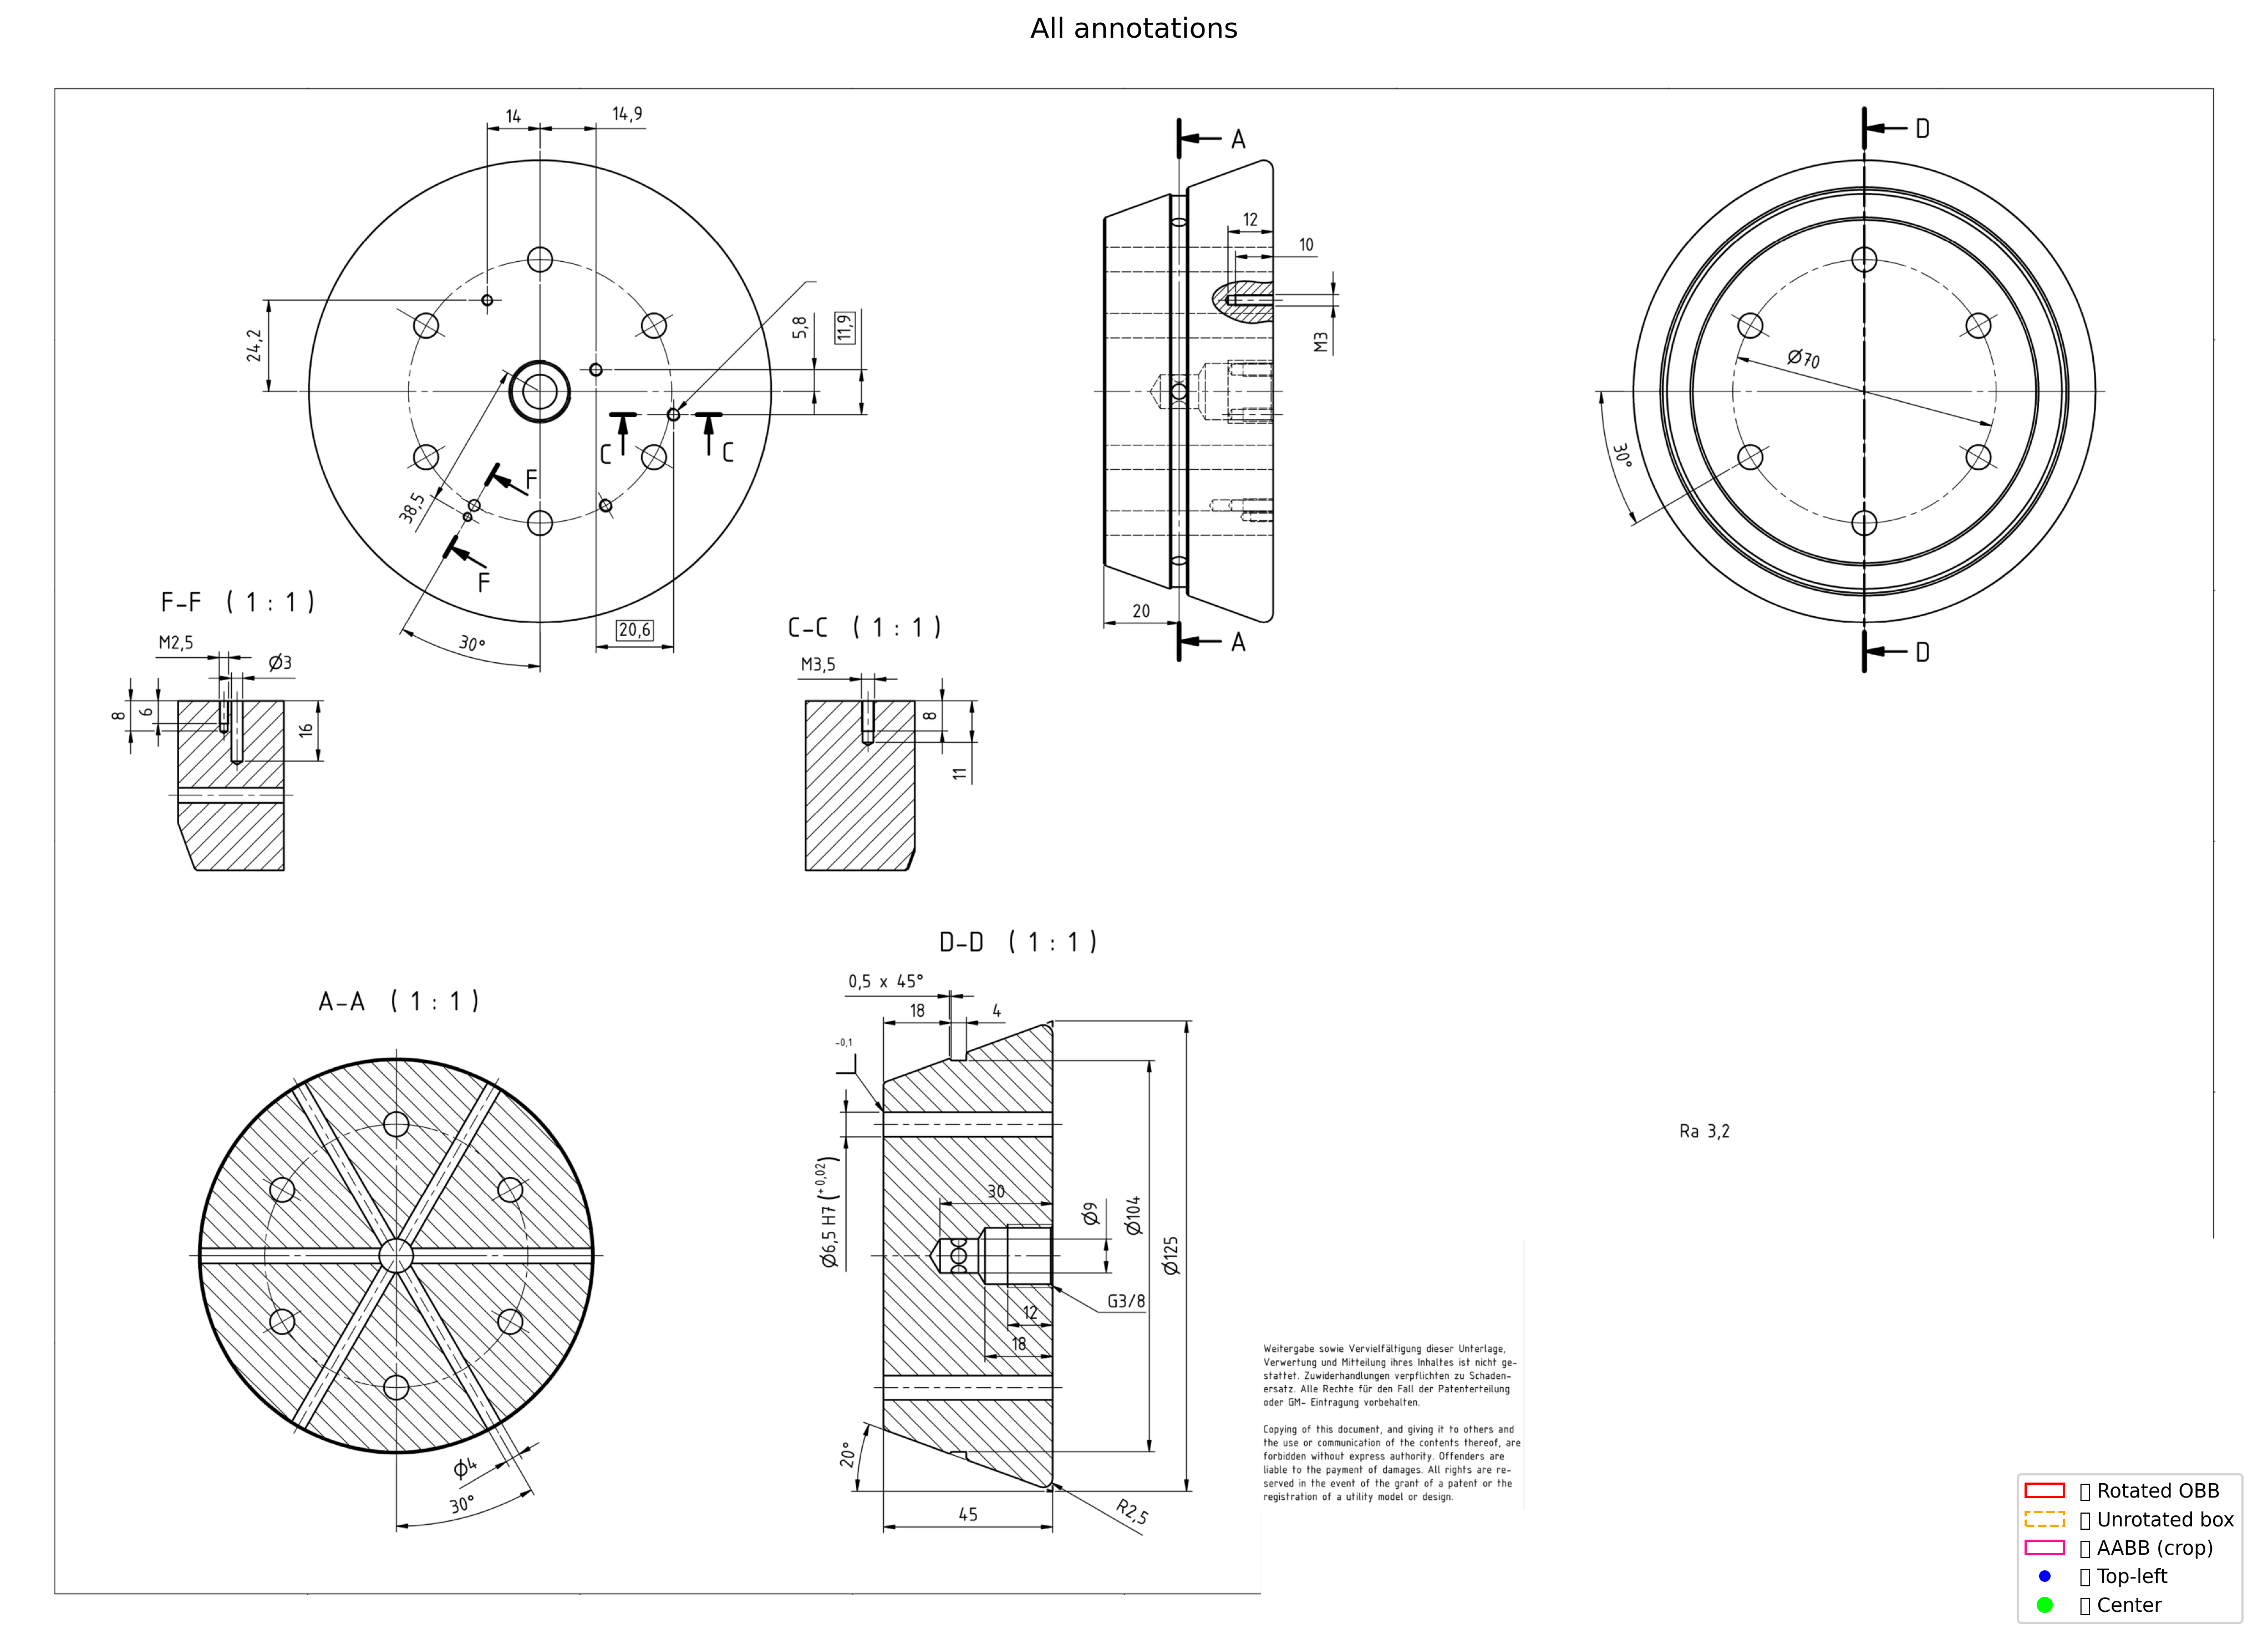

In [24]:

DEBUG_IMAGES_DEST = Path("../pipeline_prep/debug_imgs/")

# ---------------------------
# MAIN UPDATE
# ---------------------------
def update_rotations(target_image_id: int = 1, debug: bool = False):
    coco_default_4obb = load_coco(COCO_JSON)
    coco_updated_5obb = load_coco(COCO_5OBB)
    coco_pred_5obb = deepcopy(coco_updated_5obb)
    model = load_model(CHECKPOINT_PATH)

    images = {img["id"]: img for img in coco_default_4obb["images"]}
    cache = {}
    records = []
    ax = None  # only initialized if debug=True

    for ann, ann_pred in zip(coco_updated_5obb["annotations"], coco_pred_5obb["annotations"]):
        if ann["image_id"] != target_image_id:
            continue

        cx, cy, w, h, orig_rot = ann["bbox"]
        if not is_valid_rotation(orig_rot):
            continue

        fname = images[ann["image_id"]]["file_name"]
        full_img = load_image_if_needed(fname, cache)
        if full_img is None:
            continue

        # Init plot (once)
        if debug and ax is None:
            fig, ax = init_debug_canvas(full_img)

        
        ann_id=ann["id"]
        rotated_box = crop_obb_exact_mask_trim(full_img, cx, cy, w, h, orig_rot,
                       pad=0) 
        
        out_file = DEBUG_IMAGES_DEST / f"{Path(fname).stem}_{ann_id}.png"
        cv2.imwrite(str(out_file), rotated_box)

        
        pred_rot = predict_angle(model, rotated_box)

        records.append({
            "ann_id": ann["id"],
            "img_id": ann["image_id"],
            "file_name": fname,
            "bbox": [cx, cy, w, h, orig_rot],
            "orig_rot": orig_rot,
            "pred_rot": pred_rot
        })
        
        
        
        
        logger.info(f" Original {orig_rot}° → Predicted {pred_rot}° Ann ID {ann_id}")


        # 🟢 Update angle only if it changed (rest of bbox stays the same)
        if pred_rot != orig_rot:


            ann_pred["bbox"] = [cx, cy, w, h, pred_rot]
            ann_pred.setdefault("attributes", {})["rotation"] = pred_rot
        else:
            ann_pred["bbox"] = [cx, cy, w, h, orig_rot]


            

    # 💾 Save updated 5OBB predictions
    save_coco(coco_pred_5obb, PRED_JSON)

    # 🔍 Log summary
    df = pd.DataFrame(records)
    df.to_csv("./results.csv")
    print("\n=== Summary ===")
    print(df.to_string(index=False))

    if debug and ax:
        show_debug_legend(ax)
        plt.tight_layout()
        plt.show()



if __name__ == "__main__":
    update_rotations(target_image_id=2, debug=True)
    


In [ ]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
from pathlib import Path
import pandas as pd

def show_image_with_annotations_from_coco(coco_json_path: Path,
                                          images_dir: Path,
                                          image_filename: str,
                                          show_centres: bool = True,
                                          centre_color: str = "lime") -> None:
    """
    Display one COCO image with all rotated bounding boxes from a COCO-style JSON.
    """

    # Load COCO data
    with open(coco_json_path, "r", encoding="utf-8") as f:
        coco = json.load(f)

    print(coco.keys())
    # Get image_id from image filename
    image_entry = next((img for img in coco["images"] if img["file_name"] == image_filename), None)
    if not image_entry:
        print(f"Image {image_filename} not found in COCO JSON.")
        return

    image_id = image_entry["id"]
    img_path = images_dir / image_filename

    if not img_path.exists():
        print("Image not found on disk:", img_path)
        return

    # Load image
    img = plt.imread(img_path)
    fig, ax = plt.subplots(figsize=(12, 12), dpi=300)
    ax.imshow(img, aspect="equal")
    ax.set_title(f'{image_filename} (image_id={image_id})')
    ax.axis("off")

    # Get annotations for this image
    annotations = [ann for ann in coco["annotations"] if ann["image_id"] == image_id]

    if not annotations:
        print(f"No annotations found for image_id={image_id}")
        return

    for ann in annotations:
        cx, cy, w, h, rotation = ann["bbox"]
        

        # Draw rotated rectangle
        rect = Rectangle((cx - w / 2, cy - h / 2), w, h,
                         linewidth=0.5, edgecolor="red", fill=False)
        transf = Affine2D().rotate_deg_around(cx, cy, rotation) + ax.transData
        rect.set_transform(transf)
        ax.add_patch(rect)
        ax.text(cx, cy, f'{rotation:.1f}°', color='green', fontsize=8, ha='right', va='top')

        if show_centres:
            ax.scatter(cx, cy, color=centre_color, s=1, zorder=1)

    plt.show()


dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])


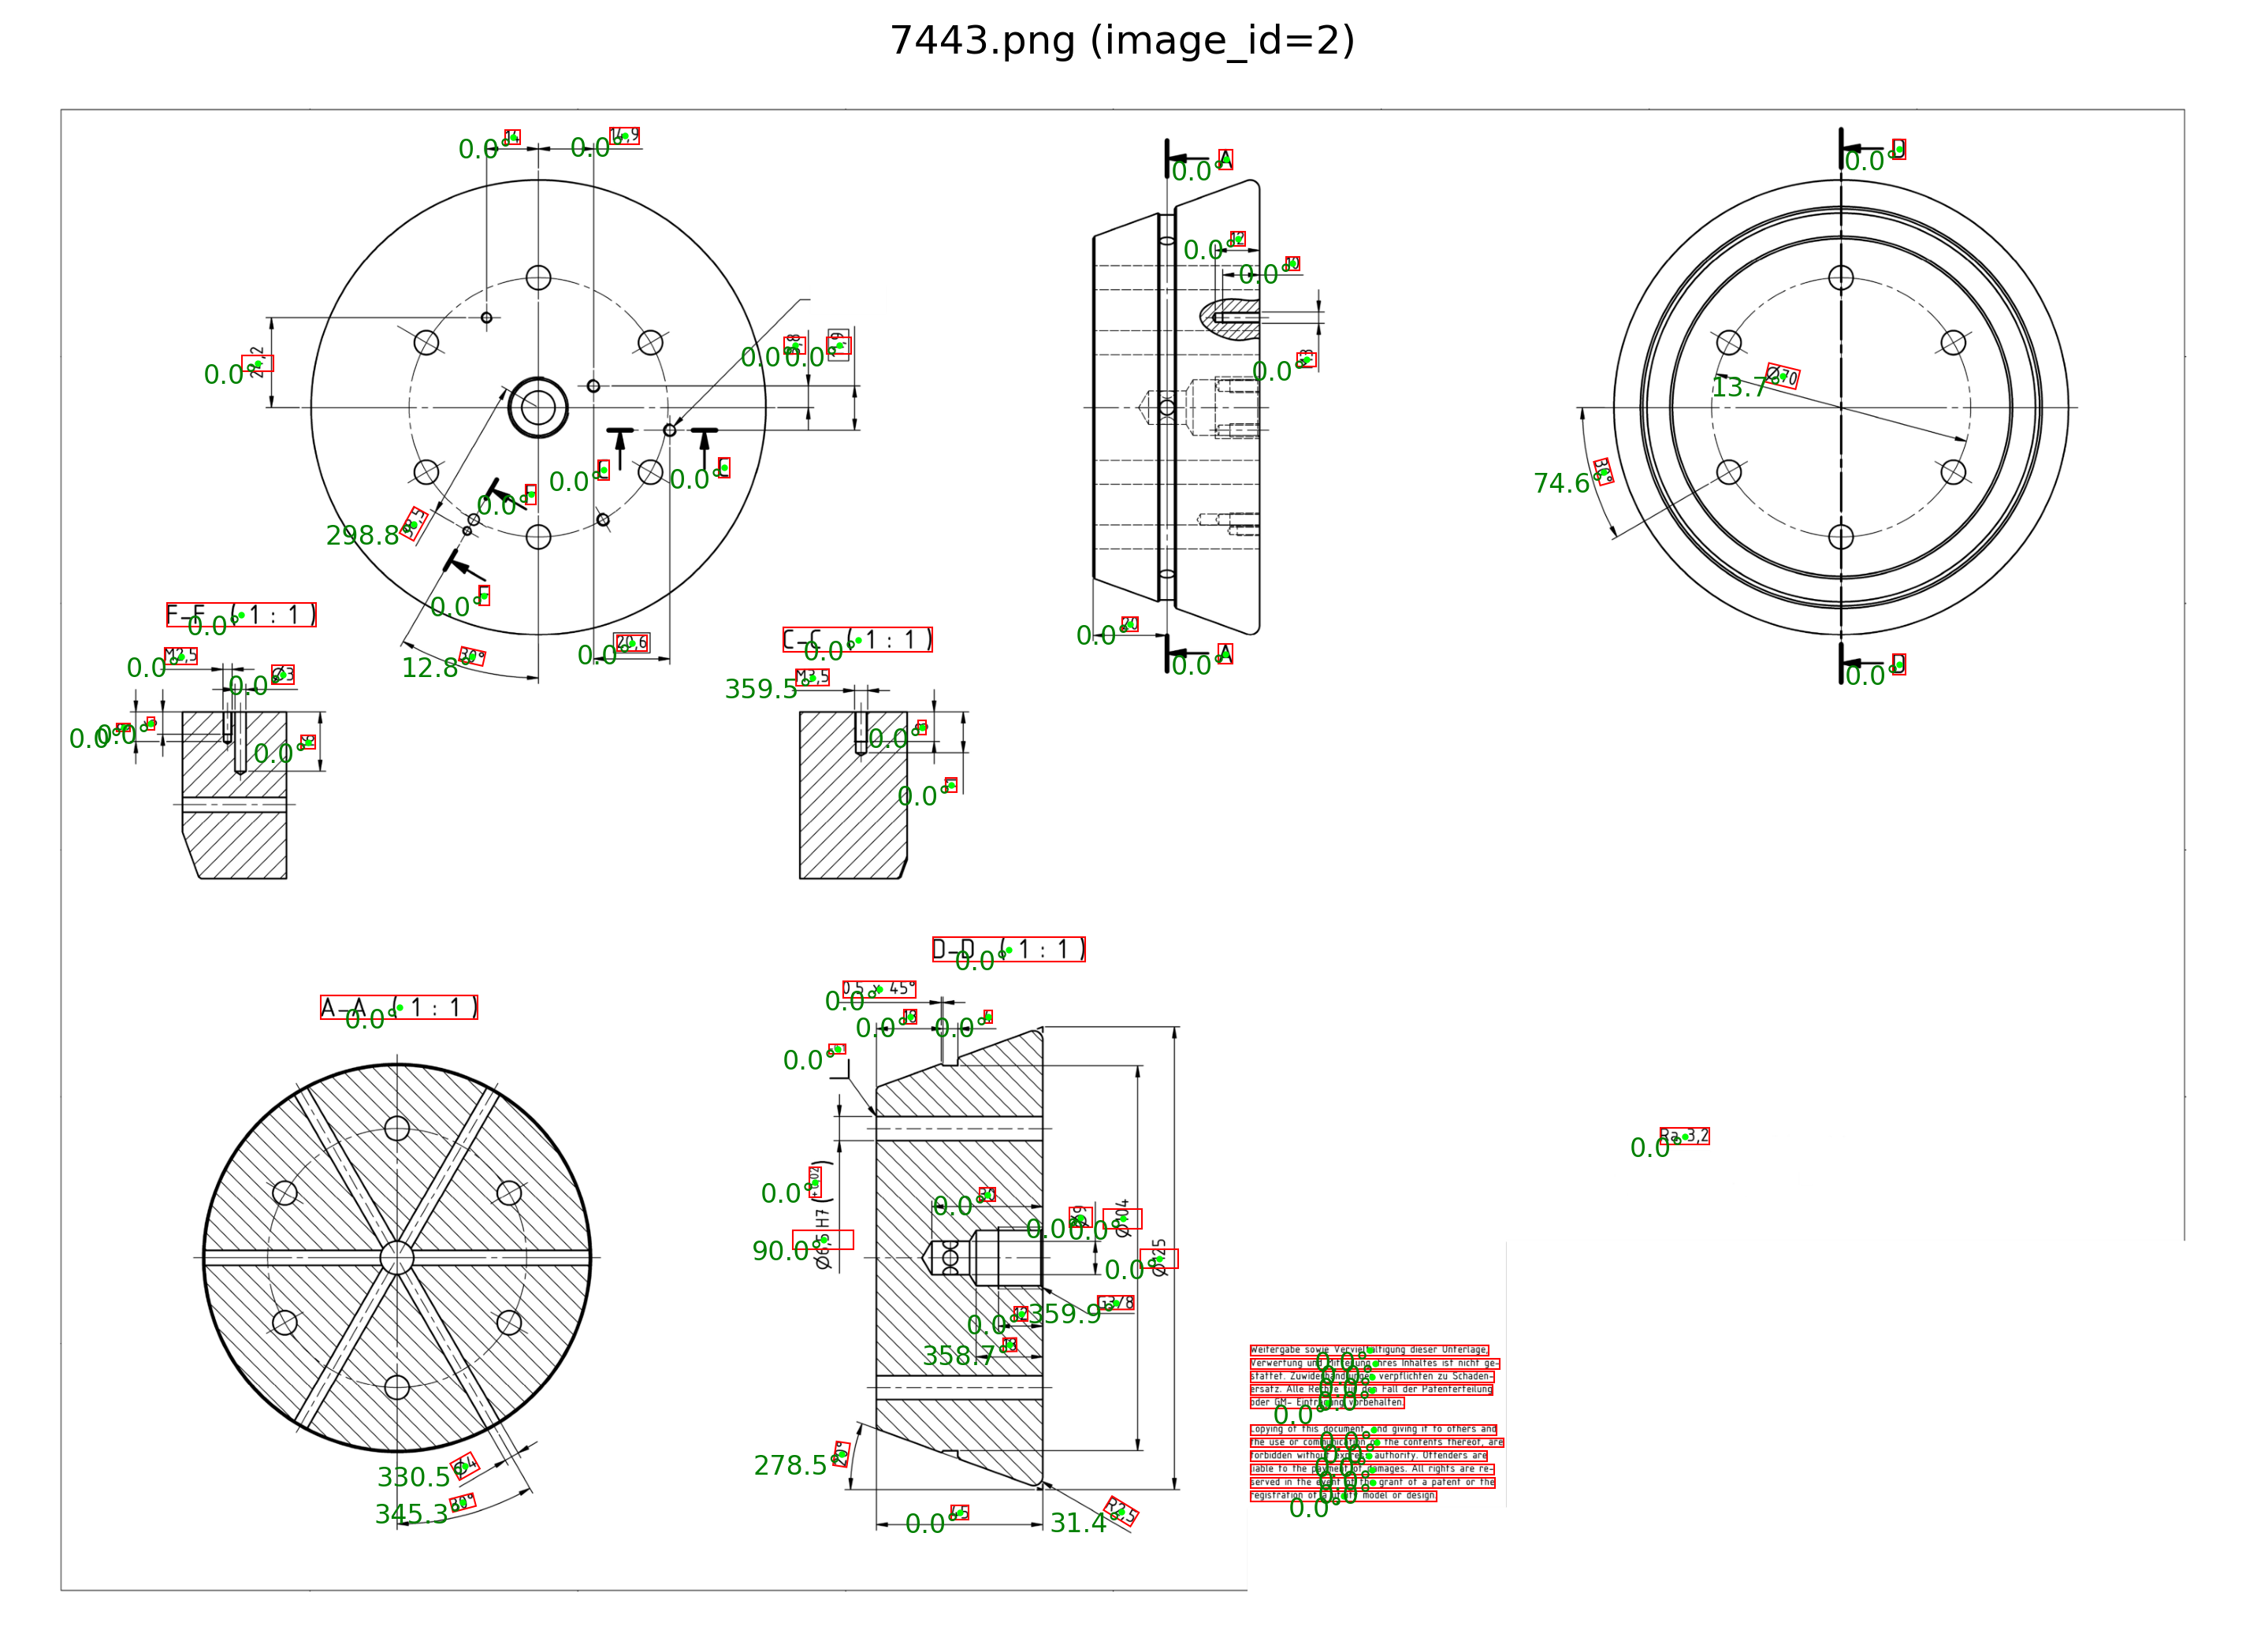

In [ ]:
show_image_with_annotations_from_coco(
    coco_json_path=Path("../data/rotation/batches/rotation_20250721_01/annotations/instances_predicted.json"),
    images_dir=Path("../data/rotation/batches/rotation_20250721_01/images/default"),
    image_filename="7443.png"
)


dict_keys(['licenses', 'info', 'categories', 'images', 'annotations'])


ValueError: not enough values to unpack (expected 5, got 4)

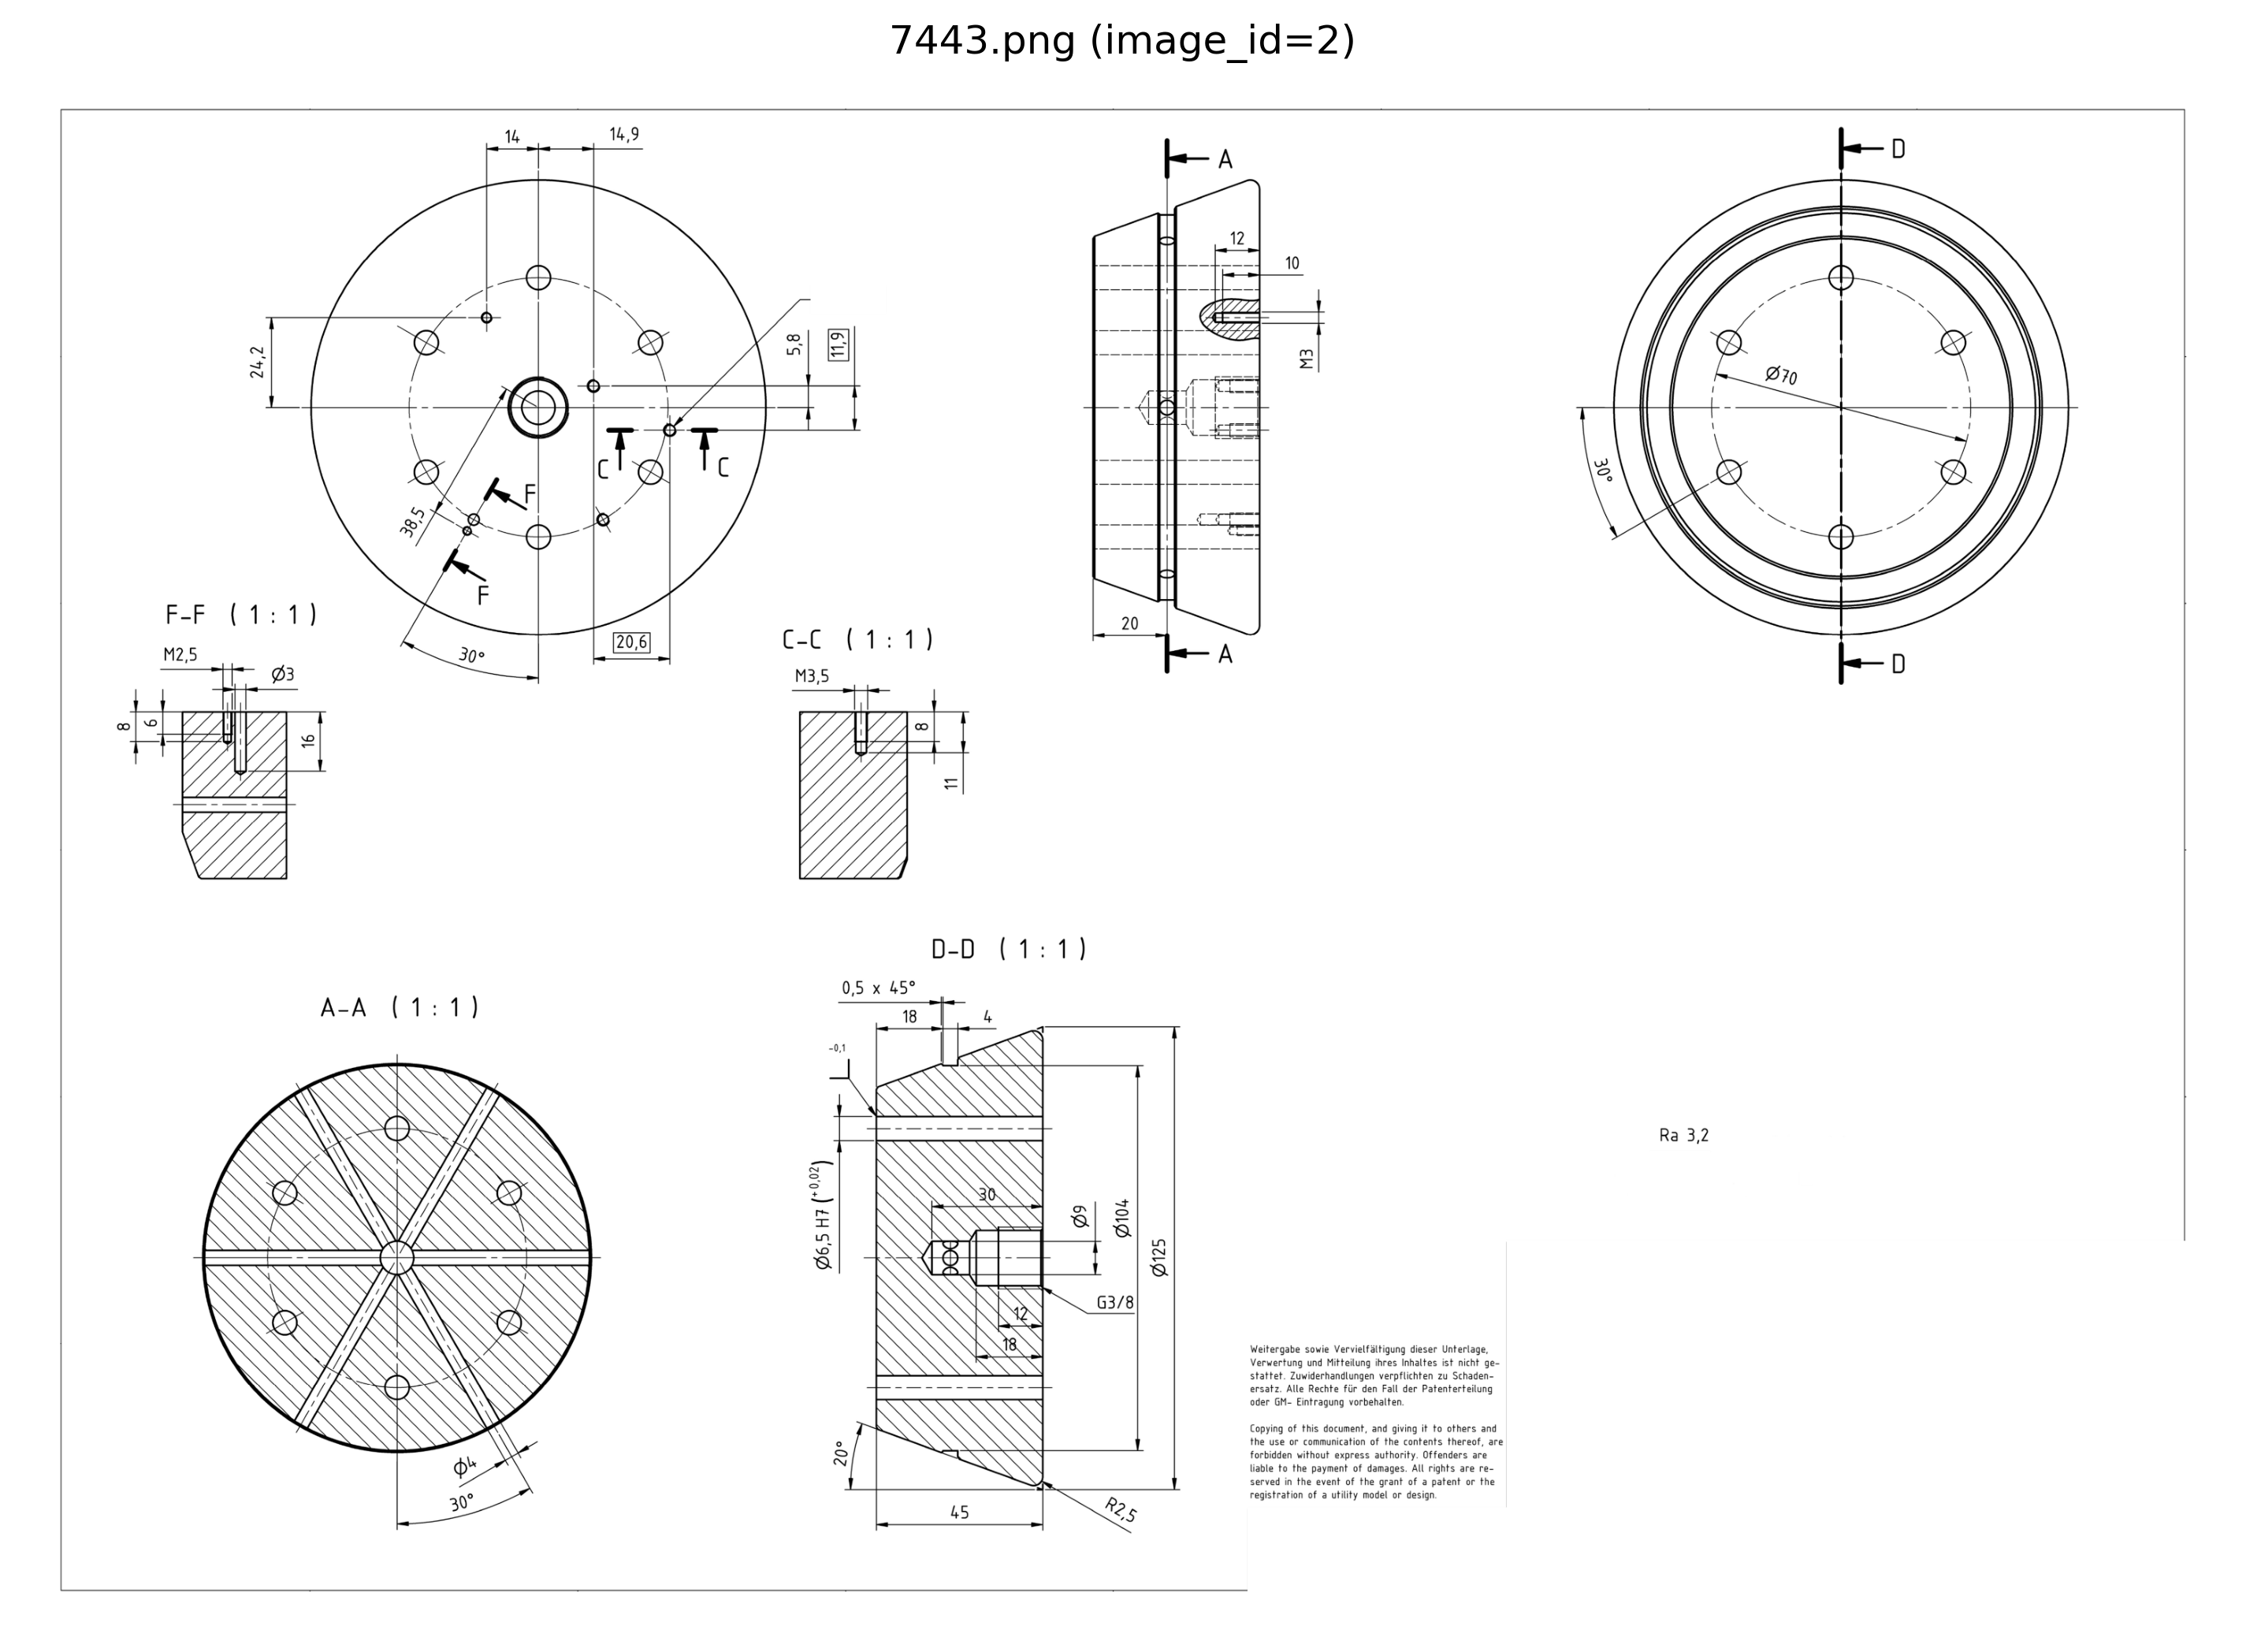

In [ ]:
show_image_with_annotations_from_coco(
    coco_json_path=Path("../data/rotation/batches/rotation_20250721_01/annotations/instances_default.json"),
    images_dir=Path("../data/rotation/batches/rotation_20250721_01/images/default"),
    image_filename="7443.png"
)
